# Youtube Conversation Prediction
## CS/INFO 4300 Language and Information

In [1]:
from __future__ import print_function
from __future__ import division
import numpy as np
import json

import httplib2
import os
import sys
sys.path.append ('/data_collection/') # so that we can import captions3
import datetime
import json
from math import sqrt

from apiclient.discovery import build
from apiclient.errors import HttpError

%matplotlib inline
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer

In [2]:
#Function to get distribution
import isodate
from __future__ import division
import numpy as np

def get_speech_distr(vid_data, partition_len=.1):
    # Get toal duration of video
    duration = isodate.parse_duration(vid_data["video_length"]).seconds
    # Go over captions
    hist_bins = [0]*(int(100/partition_len))
    for line in vid_data["captions"]:
        dur   = float(line["dur"])
        start = float(line["start"])
        end   = dur+start
        start_percent = (start/duration) * 100
        end_percent   = (end/duration) * 100
        #end_percent = 99 if end_percent == 100 else end_percent #corner case
        start_index = int(start_percent/partition_len)
        end_index   = int(end_percent/partition_len)
        end_index   = len(hist_bins)-1 if len(hist_bins) <= end_index else end_index #corner case
        #add to bins
        #print(start_index, end_index)
        for i in range(start_index, end_index+1):
            hist_bins[i] += 1
    #Converting to values
    freqs = []
    for freq_idx, freq in enumerate(hist_bins):
        freq_num = (freq_idx * partition_len) + (partition_len/2)
        for _ in range(freq):
            freqs.append(freq_num)
    return freqs

def calc_stats(freqs):
    """ Returns npArray for mean, median and variance """
    freqs = np.array(freqs)
    return np.array([np.mean(freqs), np.median(freqs), np.std(freqs)])

def get_stats(vid_data, partition_len=.1):
    return calc_stats(get_speech_distr(vid_data ,partition_len=partition_len))

# 1. Load the data from the JSON file.

In [3]:
with open('data/big_data_approx.json') as json_file:   
    video_data = json.load(json_file)

In [4]:
video_num_comments, video_captions = np.array([ (video_datum["score"], video_datum["captions"]) 
                                              for _,video_datum in video_data.iteritems() ]).T

In [5]:
stats = np.array([get_stats(video_datum) for _,video_datum in video_data.iteritems()])    

In [6]:
categories = np.array([video_datum["categories"][0] for _,video_datum in video_data.iteritems()])  

In [7]:
topics = np.array([video_datum["topics"] for _,video_datum in video_data.iteritems()]) 

##Binarize the topic ids

In [8]:
from sklearn.preprocessing import MultiLabelBinarizer

In [9]:
mlb = MultiLabelBinarizer()
X = mlb.fit_transform(topics)

In [10]:
print(X.shape)
print(np.where(X[11]))
print(mlb.classes_[[0, 2, 16, 21]])

(2268, 2217)
(array([319]),)
[u'/m/0100bl2t' u'/m/0101sf98' u'/m/010rd1rs' u'/m/010ybysh']


In [11]:
#Remove topics with 2 or fewer videos

col_mask = np.fromiter( ( col_sum>1 for col_sum in np.sum(X,axis=0) ), dtype=bool)
#topic_ids = mlb.classes_[col_mask]
X = X[:,col_mask]
print(X.shape)

(2268, 560)


##  Consolidate caption text for each video into one string


In [12]:
# Define a stemmer and lemmatizer for use with our captions
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
#Method to check for numbers
def has_numbers(inputString):
    return any(char.isdigit() for char in inputString)

In [13]:
combined_video_captions = []
video_num_comments_cut  = []
for caption_data_list,num_comments in zip(video_captions,video_num_comments):
    text = ""
    if caption_data_list is not None:
        video_num_comments_cut.append(num_comments)
        for caption_data in caption_data_list:
            if caption_data is not None and "text" in caption_data:
                for word in caption_data["text"].split():
                    if (not has_numbers(word)):
                        text += (lemmatizer.lemmatize(word)+" ")
                        #text += (stemmer.stem(word)+" ")
        combined_video_captions.append(text[:-1])

In [14]:
video_captions = combined_video_captions

#2. Make a 75-25 train-test split.

Use `sklearn.cross_validation.train_test_split`. Set `random_state=0`. Make sure the train and test sizes are equal (plus/minus one)

In [15]:
from sklearn.cross_validation import train_test_split

In [16]:
print(len(video_num_comments_cut))
print(len(combined_video_captions))

2268
2268


In [17]:
Y_train, Y_test, video_captions_train, video_captions_test  = train_test_split(video_num_comments_cut, combined_video_captions, 
                                                                       test_size=.25, random_state=0) #split main data
stats_train, stats_test = train_test_split(stats, test_size=.25, random_state=0) #split stats
categories_train, categories_test = train_test_split(categories, test_size=.25, random_state=0)
topics_train, topics_test = train_test_split(X, test_size=.25, random_state=0) # X refers to the binarized topic ids

print(topics_train[0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [18]:
print(len(Y_test))
print(len(Y_train))
print(len(video_captions_test))
print(len(video_captions_train))
print(len(stats_train))
print(len(stats_test))
print(len(categories_train))
print(len(categories_test))

567
1701
567
1701
1701
567
1701
567


(array([ 367.,  105.,   23.,   16.,   11.,    9.,    9.,    5.,    7.,
           2.,    1.,    2.,    2.,    2.,    1.,    0.,    1.,    0.,
           1.,    0.,    0.,    1.,    0.,    0.,    2.]),
 array([   0.        ,   24.03334428,   48.06668855,   72.10003283,
          96.1333771 ,  120.16672138,  144.20006565,  168.23340993,
         192.26675421,  216.30009848,  240.33344276,  264.36678703,
         288.40013131,  312.43347558,  336.46681986,  360.50016414,
         384.53350841,  408.56685269,  432.60019696,  456.63354124,
         480.66688551,  504.70022979,  528.73357406,  552.76691834,
         576.80026262,  600.83360689]),
 <a list of 25 Patch objects>)

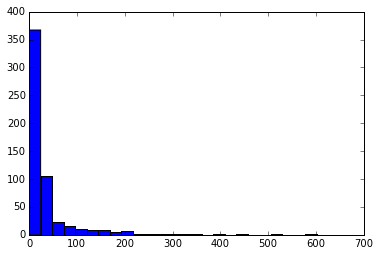

In [19]:
plt.hist(Y_test, bins=25)

(array([  1.42300000e+03,   1.62000000e+02,   5.10000000e+01,
          1.90000000e+01,   1.30000000e+01,   6.00000000e+00,
          7.00000000e+00,   5.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   5.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.00000000e+00]),
 array([    0.        ,    59.80432935,   119.6086587 ,   179.41298805,
          239.2173174 ,   299.02164674,   358.82597609,   418.63030544,
          478.43463479,   538.23896414,   598.04329349,   657.84762284,
          717.65195219,   777.45628153,   837.26061088,   897.06494023,
          956.86926958,  1016.67359893,  1076.47792828,  1136.28225763,
         1196.08658698,  1255.89091632,  1315.69524567,  1375.49957502,
         1435.30390437,  1495.10823372]),
 <

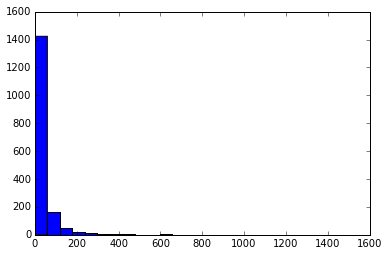

In [20]:
plt.hist(Y_train, bins=25)

### 3. Build the document-term matrices

Use `sklearn.feature_extraction.TfidfVectorizer`. Use unigrams only, disable idf, use `l1` normalization. 

Resulting matrices are `X_train` and `X_test`.

**Note:** Remember to just `fit` on the training data. If a word occurs only in the test documents, our model should **not** be aware that the word exists, as we are trying to evaluate the performance on completely unseen data.

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
tfv = TfidfVectorizer(ngram_range=(1,2), lowercase=True, strip_accents="unicode", 
                      stop_words='english', use_idf=False, norm='l1', min_df=2, max_df=.5)
tfv.fit(video_captions_train)
X_train = tfv.transform(video_captions_train)
X_test  = tfv.transform(video_captions_test)

In [23]:
print(X_train.shape)
print(X_test.shape)

(1701, 76895)
(567, 76895)


## Reudce Dimensions

In [19]:
from sklearn.decomposition import TruncatedSVD
svdt = TruncatedSVD(n_components=60, random_state=42)
X_train = svdt.fit_transform(X_train)
print('Shape of truncated_svd_sparse_data:', X_train.shape)
print('% Variance explained by SVD:', svdt.explained_variance_ratio_.sum() )

Shape of truncated_svd_sparse_data: (1701, 60)
% Variance explained by SVD: 0.470753913811


In [20]:
#X_test = svdt.transform(X_test)


##Combine Features

In [24]:
import scipy.sparse as sp

In [22]:
#convert to sparse
stats_train = sp.csr_matrix(stats_train)
stats_test = sp.csr_matrix(stats_test)
X_train = sp.hstack((X_train, stats_train))
X_test  = sp.hstack((X_test, stats_test))
print(X_train.shape)
print(X_test.shape)

(1701, 63)
(567, 63)


In [23]:
video_num_comments = None
video_captions = None
combined_video_captions = None

##Use just categories

In [96]:
categories_train = sp.csr_matrix(categories_train.reshape((1701, 1)))
categories_test = sp.csr_matrix(categories_test.reshape((567, 1)))
X_train = categories_train
X_test = categories_test
print(X_train.shape)
print(X_test.shape)

NotImplementedError: 

##Categories plus captions

In [100]:
#categories_train = sp.csr_matrix(categories_train.reshape((1701, 1)))
#categories_test = sp.csr_matrix(categories_test.reshape((567, 1)))
X_train = sp.hstack((X_train, categories_train))
X_test  = sp.hstack((X_test, categories_test))
print(X_train.shape)
print(X_test.shape)

(1701, 76896)
(567, 76896)


##Categories plus stats

In [111]:
X_train = sp.hstack((stats_train, categories_train))
X_test  = sp.hstack((stats_test, categories_test))
print(X_train.shape)
print(X_test.shape)

(1701, 4)
(567, 4)


##Just using topics

In [198]:
topics_train = sp.csr_matrix(topics_train)
topics_test = sp.csr_matrix(topics_test)
X_train = topics_train
X_test = topics_test
print(X_train.shape)
print(X_test.shape)

(1701, 560)
(567, 560)


##Use everything

In [25]:
topics_train = sp.csr_matrix(topics_train)
topics_test = sp.csr_matrix(topics_test)

stats_train = sp.csr_matrix(stats_train)
stats_test = sp.csr_matrix(stats_test)

categories_train = sp.csr_matrix(categories_train.reshape((1701, 1)))
categories_test = sp.csr_matrix(categories_test.reshape((567, 1)))
X_train = sp.hstack((X_train, categories_train)) # Combining captions and categories
X_test  = sp.hstack((X_test, categories_test))

X_train = sp.hstack((X_train, topics_train)) # Adding in topics
X_test  = sp.hstack((X_test, topics_test))

X_train = sp.hstack((X_train, stats_train))
X_test  = sp.hstack((X_test, stats_test))

print(X_train.shape)
print(X_test.shape)

(1701, 77459)
(567, 77459)


# 4. Predict using a random guess baseline

Use a random classifier from `sklearn.dummy.DummyClassifier`.  Set `strategy="stratified"`? Set `random_state=0`, to get the same result every time, since randomness is involved.

In [26]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [27]:
dummy = DummyRegressor(strategy="median")
dummy.fit(X_train, Y_train)
Y_pred_med = dummy.predict(X_test)
print(mean_absolute_error(Y_test, Y_pred_med))

30.5913668479


##Setup GridSearch

In [28]:
from sklearn.grid_search import GridSearchCV
def my_mae_scorer(estimator, X, y):
    """This function is just glue code for the scikit-learn scorer API.
    See http://scikit-learn.org/stable/modules/model_evaluation.html#implementing-your-own-scoring-object
    =Parameters=
    estimator:
        the model that should be evaluated (e.g., the scikit-learn classifier)
    X: array-like, shape (n_samples, n_features)
        the test data
    y: array-like, shape (n_samples, n_labels)
        the ground truth target for X.
    =Returns:=
    mae, float
        the mean absolute error"""
    y_pred = estimator.predict(X)
    return mean_absolute_error(y, y_pred)

# 6. Train and evaluate SVM Regression.

We will use `sklearn.svm.SVR()" as our initial classifier (Support Vector Regression)

In [267]:
from sklearn.svm import SVR
svm_regression_classifier = SVR()

In [268]:
svm_regression_classifier.fit(X_train, Y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.0,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [269]:
Y_pred_svr = svm_regression_classifier.predict(X_test)
my_mae_score_svr = mean_absolute_error(Y_test, Y_pred_svr)

In [270]:
print(my_mae_score_svr)

30.5499519386


##Logisitc Regression

In [71]:
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression(class_weight='auto')

param_grid = {'C': [1,.1,.01,.001,.0001], 'fit_intercept': [True,False], 'class_weight':[None,'auto'], 'multi_class':['ovr'], 'solver':['liblinear']}}
grid = GridSearchCV(log_clf,
                    param_grid,
                    cv=3,
                    scoring=my_mae_scorer,
                    verbose=True,
                    n_jobs=4)
grid.fit(X_train, Y_train)
log_clf_best = grid.best_estimator_
print(grid.best_params_)
print(my_mae_scorer(kridge_clf_best, X_test, Y_test))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


ValueError: Unknown label type: array([  97.90175654,   10.44481947,  129.89977382, ...,   67.8717109 ,
         18.13608747,    6.71579269])

## KNN Regression

In [74]:
from sklearn.neighbors import KNeighborsRegressor
knn_regression_classifier = KNeighborsRegressor()

knn_regression_classifier.fit(X_train, Y_train)
num_comments_pred_knn = knn_regression_classifier.predict(X_test)
print(mean_absolute_error(Y_test, num_comments_pred_knn))

40.5305073369


#LassoLarsCV

In [29]:
from sklearn.linear_model import LassoLarsCV, LassoCV
llcv_clf = LassoCV(n_jobs=4, verbose=True)
llcv_clf.fit(X_train.toarray(), Y_train)
print(my_mae_scorer(llcv_clf, X_test, Y_test))

MemoryError: 

##RandomForestRegressor Regression

In [63]:
from sklearn.ensemble import RandomForestRegressor
forest_regression_classifier = RandomForestRegressor()

forest_regression_classifier.fit(X_train, Y_train)
Y_pred_forest = forest_regression_classifier.predict(X_test)
print(mean_absolute_error(Y_test, Y_pred_forest))

34.1289069967


# 7. Train and evaluate Linear Regression.

We will be using `sklearn.linear_model.LinearRegression()" as an additional classifier

In [53]:
from sklearn.linear_model import LinearRegression
lreg_clf = LinearRegression(normalize=True)

In [54]:
grid = GridSearchCV(estimator=lreg_clf,
                    param_grid=dict(normalize=[True]), 
                    scoring=my_mae_scorer,
                    cv=3,
                    verbose=True,
                    n_jobs=4)
grid.fit(X_train, Y_train)
print(grid.best_params_)
lreg_clf_best = grid.best_estimator_
print(my_mae_scorer(lreg_clf_best, X_test, Y_test))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
{'normalize': True}
41.2845246809


[Parallel(n_jobs=4)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    0.0s finished


# 8. Train and evaluate Lasso Regression.

We will be using "sklearn.linear_model.Lasso" as an additional classifier

In [40]:
from sklearn.linear_model import Lasso
lasso_clf = Lasso()

In [42]:
grid = GridSearchCV(estimator=lasso_clf,
                    param_grid=dict(alpha=[1,.1,.01,.001,.0001]), 
                    scoring=my_mae_scorer,
                    cv=3,
                    verbose=True,
                    n_jobs=4)
grid.fit(stats_train, Y_train)
print(grid.best_params_)
lasso_clf_best = grid.best_estimator_
print(my_mae_scorer(lasso_clf_best, stats_test, Y_test))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   9 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    0.1s finished


{'alpha': 0.0001}
41.4763686198


# 8.2. Train and evaluate Kernelized Ridge Regression.

We will be using "sklearn.linear_model.Lasso" as an additional classifier

In [41]:
from sklearn.kernel_ridge import KernelRidge
kridge_clf = KernelRidge()

In [42]:
param_grid = [
    {'alpha': [1,.1,.01,.001,.0001], 'kernel': ['linear']},
    {'alpha': [1,.1,.01,.001,.0001], 'kernel': ['rbf']},
    {'alpha': [1,.1,.01,.001,.0001], 'kernel': ['polynomial'], 'degree' : [1,2,3,4]},
    {'alpha': [1,.1,.01,.001,.0001], 'kernel': ['sigmoid']}
 ]
grid = GridSearchCV(kridge_clf,
                    param_grid,
                    cv=3,
                    scoring=my_mae_scorer,
                    verbose=True,
                    n_jobs=4)
grid.fit(X_train, Y_train)
kridge_clf_best = grid.best_estimator_
print(grid.best_params_)
print(my_mae_scorer(kridge_clf_best, X_test, Y_test))
#mean: 35.91859, std: 1.46616, params: {'alpha': 0.01, 'kernel': 'linear'}

Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=4)]: Done   1 jobs       | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  50 jobs       | elapsed:   11.2s
[Parallel(n_jobs=4)]: Done  99 out of 105 | elapsed:   47.4s remaining:    2.9s
[Parallel(n_jobs=4)]: Done 105 out of 105 | elapsed:  1.1min finished
/usr/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:147: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:147: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:147: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/lib/python2.7/site-packages/sklearn/linear_mo

{'alpha': 0.0001, 'degree': 4, 'kernel': 'polynomial'}
395.705038419


In [50]:
for score in grid.grid_scores_:
    print(score)

mean: 40.67060, std: 1.54023, params: {'alpha': 1, 'kernel': 'linear'}
mean: 38.42879, std: 1.70954, params: {'alpha': 0.1, 'kernel': 'linear'}
mean: 39.64367, std: 2.69036, params: {'alpha': 0.01, 'kernel': 'linear'}
mean: 44.40017, std: 3.81480, params: {'alpha': 0.001, 'kernel': 'linear'}
mean: 48.01060, std: 5.07282, params: {'alpha': 0.0001, 'kernel': 'linear'}
mean: 40.29521, std: 1.46154, params: {'alpha': 1, 'kernel': 'rbf'}
mean: 40.25894, std: 1.66128, params: {'alpha': 0.1, 'kernel': 'rbf'}
mean: 40.17278, std: 1.98780, params: {'alpha': 0.01, 'kernel': 'rbf'}
mean: 41.76793, std: 2.08452, params: {'alpha': 0.001, 'kernel': 'rbf'}
mean: 49.40669, std: 1.83296, params: {'alpha': 0.0001, 'kernel': 'rbf'}
mean: 41.32254, std: 1.43809, params: {'alpha': 1, 'degree': 1, 'kernel': 'polynomial'}
mean: 40.01709, std: 1.46816, params: {'alpha': 1, 'degree': 2, 'kernel': 'polynomial'}
mean: 43.43068, std: 1.14147, params: {'alpha': 1, 'degree': 3, 'kernel': 'polynomial'}
mean: 52.9092

In [44]:
my_mae_scorer(kridge_clf_best, X_train, Y_train)

33.591206221385349

## ElasticNet Regression

In [39]:
from sklearn.linear_model import ElasticNet
en_clf = ElasticNet()
param_grid = {'alpha': [1,.9,.8,.7,.6,.5,.4,.3,.2,.1,.01, .001, .0001], 
              'l1_ratio': [1,.9,.8,.7,.6,.5,.4,.3,.2,.1,.05]}
grid = GridSearchCV(en_clf,
                    param_grid,
                    cv=3,
                    scoring=my_mae_scorer,
                    verbose=100)
grid.fit(X_train, Y_train)
best_params_en = grid.best_estimator_
print(grid.best_params_)
print(my_mae_scorer(best_params_en, X_test, Y_test))
#mean: 35.91859, std: 1.46616, params: {'alpha': 0.01, 'kernel': 'linear'}

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:   48.2s
[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:  3.3min
/usr/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


Fitting 3 folds for each of 143 candidates, totalling 429 fits
59.0229410568


[Parallel(n_jobs=1)]: Done 429 out of 429 | elapsed: 39.1min finished
